# Chapter 7. 앙상블 학습과 랜덤 포레스트

무작위로 선택된 수천명의 사람에게 복잡한 질문을 하고 대답을 모은다고 가정합시다. 많은 경우 이렇게 모은 답이 전문가의 답보다 낫습니다. 이를 *대중의 지혜*라고 합니다.

이와 비슷하게 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있을 것입니다. 일련의 예측기를 **앙상블**이라고 부르기 때문에 이를 **앙상블 학습**(ensemble learning)이라고 하며, 앙상블 학습 알고리즘을 앙상블 방법이라고 합니다. 

예를 들어 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있습니다. 예측을 하려면 모든 개별 트리의 예측을 구하면 됩니다. 그런 다음 가장 많은 선택을 받은 클래스를 예측으로 삼습니다. 결정 트리의 앙상블을 **랜덤 포레스트**(random forest)라고 합니다. 가장 간단한 방법이지만, 오늘날 가장 강력한 머신러닝 알고리즘 중 하나입니다.


이 장에서는 **배깅, 부스팅, 스태킹** 등 가장 인기있는 앙상블 방법을 설명하겠습니다.



## 1. 투표 기반 분류기

정확도가 80%인 분류기 여러개를 훈련시켰다고 가정합시다. 아마도 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, k-최근접 이웃 분류기 등을 가지고 있을 수 있습니다.

더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것입니다. 이렇게 다수결 투표로 정해지는 분류기를 **직접 투표**(hard voting) 분류기라고 합니다.

조금 놀랍게도, 이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많습니다. 사실 각 분류기가 약한 학습기일지라도, 많고 다양하다면 앙상블은 강한 학습기가 될 수 있습니다.

다음은 여러 분류기를 조합하여 사이킷런의 **투표 기반 분류기**(`VotingClassifier`)를 만들고 훈련시키는 코드입니다.


In [25]:
# moons 데이터셋을 읽어와 학습시켜봅시다!
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape)

(375, 2) (125, 2)


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=10)
svm_clf = SVC(gamma='auto')

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('rf', RandomForestClassifier(n_estimators=10)),
                             ('svc', SVC(gamma='auto'))])

각 분류기의 테스트셋 정확도를 확인해봅시다.

In [27]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.888
VotingClassifier 0.896


VoingClassifier가 꽤 좋은 성적을 보이고 있는 것 같죠? 

모든 분류기가 클래스의 확률을 예측할 수 있으면 (즉, `predict_proba()`메서드가 있으면), 개별 분류기의 예측의 평균을 내어 확률이 가장 높은 클래스를 예측할 수 있습니다. 이를 **간접 투표**(soft voting)이라고 합니다. 이 방식은 확률이 높은 투표에 비중을 두기 때문에 직접 투표 방식보다 성능이 높습니다. 이 방식을 사용하기 위해서는 `voting='hard'`를 `voting='soft'`로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됩니다. `SVC`는 기본값에서는 클래스 확률을 제공하지 않으므로 `probability` 매개변수를 `True`로 지정해야 합니다. (이렇게하면 클래스 확률을 추정하기 위해 교차검증을 사용하므로 훈련 속도가 느려지지만 `SVC`에서 `predict_proba()`를 사용할 수 있습니다.) 앞의 코드를 간접 투표 방식을 사용하도록 변경하면 91%의 정확도를 얻을 것입니다.

## 2. 배깅과 페이스팅

앞서 말했듯이 다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것입니다. 또 다른 방법은 같은 알고리즘을 사용하지만 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것입니다.

훈련 세트에서 중복을 허용하여 샘플링하는 방식을 **배깅**(bagging)(bootstrap aggregating의 줄임말)이라고 하며, 중복을 허용하지않고 샘플링하는 방식을 **페이스팅**(pasting)이라고 합니다.

다시 말해 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있습니다. 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링 할 수 있습니다. 이 샘플링과 훈련 과정은 아래와 같습니다.

![img](https://yganalyst.github.io/assets/images/ML/chap6/bagging1.png)

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측을 만듭니다. 수집 함수는 전형적으로 분류일 때는 **통계적 최빈값**(statistical mode)(즉, 직접 투표 분류기처럼 가장 많은 예측 결과)이고 회귀에 대해서는 평균을 계산합니다. 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소합니다. 

위 그림에서 볼 수 있듯이 *예측기는 동시에 다른 CPU코어나 서버에서 병렬로 학습시킬 수 있습니다.* 이와 유사하게 예측도 병렬로 수행할 수 있습니다. 이런 확장성 덕분에 배깅과 페이스팅의 인기가 높습니다.



### 2.1 사이킷런의 배깅과 페이스팅

사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 `BaggingClassifier`(회귀의 경우 `BagginRegressor`)를 제공합니다. 다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드입니다. 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련됩니다. 이 경우는 배깅의 경우이고, 페이스팅을 사용하려면 `bootstrap=False`로 지정하면 됩니다. `n_jobs` 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정합니다.

In [28]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

`BaggingClassifier`는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면 (즉, `predict_proba()` 함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용합니다.


아래 그림은 단일 결정 트리의 결정 경계외 500개의 트리를 사용한 배깅 앙상블의 경계를 비교한 것입니다. 둘다 moons 데이터 셋에 훈련시켰습니다. 여기서 볼 수 있듯이, 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 된 것 같습니다. 앙상블은 비슷한 편향에서 더 작은 분산을 만듭니다.

0.856


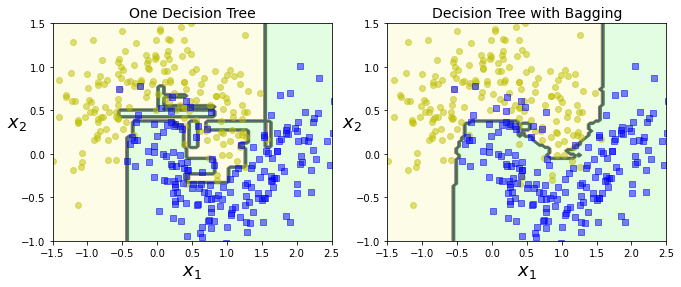

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("One Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Tree with Bagging", fontsize=14)
plt.show()

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높습니다. 하지만 이는 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킵니다. 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호합니다. 그러나 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋습니다.



### 2.2 oob 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있습니다. `BaggingClassifier`는 기본 값으로 중복을 허용하여(`bootstrap=True`) 훈련 세트 크기만큼 $m$개 샘플을 선택합니다. 

In [ ]:
$